In [1]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.preprocessing import scale
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.mosaicplot import mosaic
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

In [2]:
ID = 'TransactionID'
TARGET = 'isFraud'

In [3]:
df_train = pd.read_csv('../01_datos/train_transaction.csv')

In [4]:
df_train.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
df_train.shape

(590540, 394)

## Num missing

In [6]:
prop_missing = (df_train.isnull().sum(axis=0) / len(df_train))

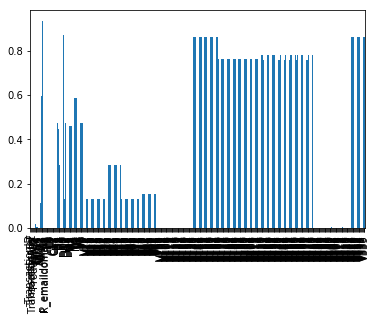

In [7]:
prop_missing.plot.bar()

## Select variables no missing for logistic regression

In [8]:
var_no_null = prop_missing[prop_missing==0]

In [9]:
train_no_null_df = df_train[var_no_null.index]

In [10]:
train_no_null_df.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14
0,2987000,0,86400,68.5,W,13926,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0
1,2987001,0,86401,29.0,W,2755,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0
2,2987002,0,86469,59.0,W,4663,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0
3,2987003,0,86499,50.0,W,18132,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0
4,2987004,0,86506,50.0,H,4497,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0


## plot

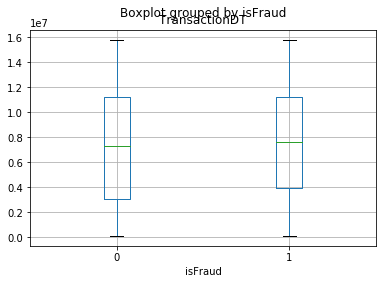

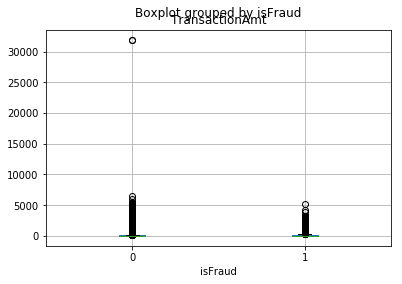

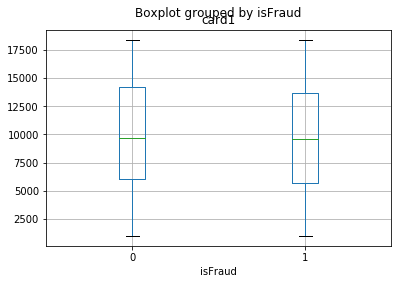

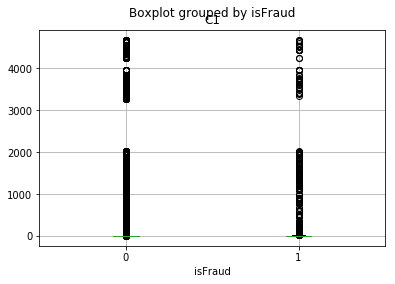

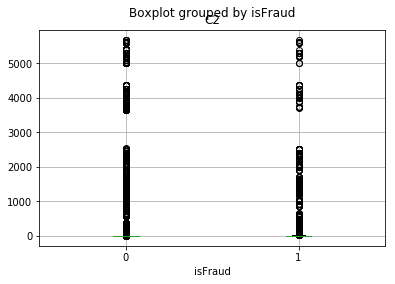

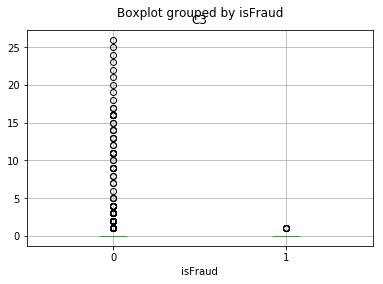

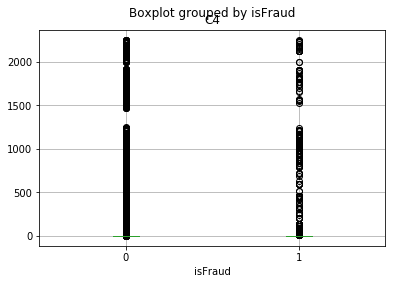

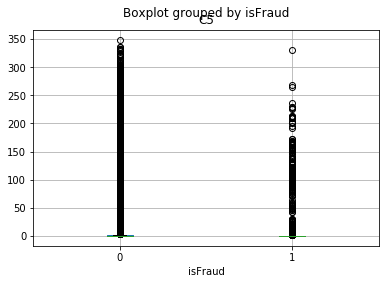

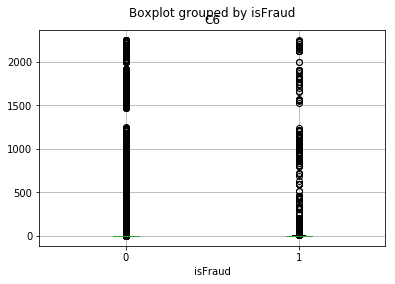

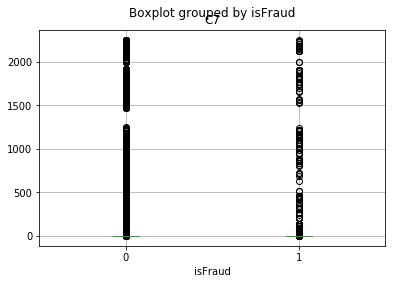

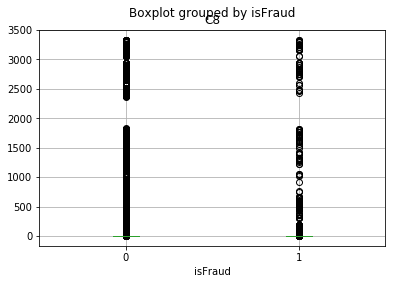

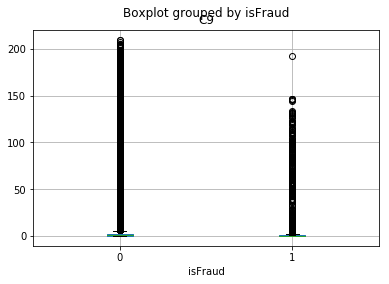

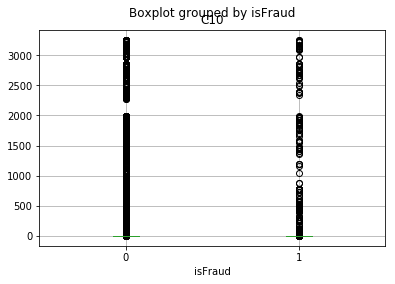

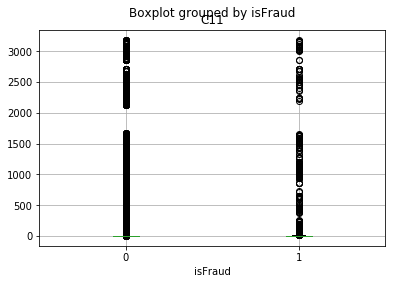

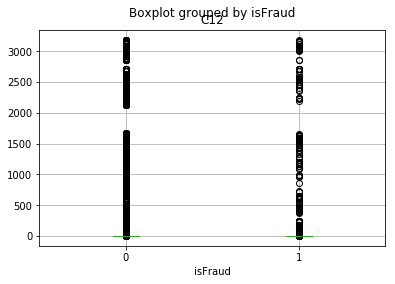

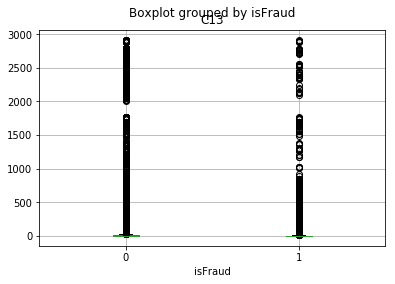

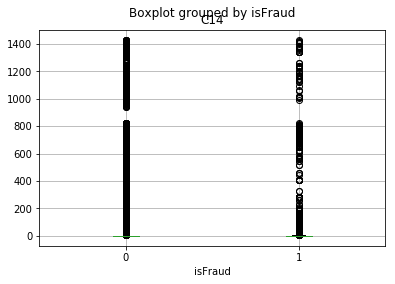

In [11]:
for var in ['TransactionDT', 'TransactionAmt', 'card1', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 
            'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14']:
    train_no_null_df.boxplot(var, by=TARGET)

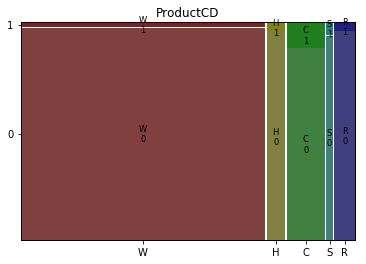

In [12]:
mosaic(train_no_null_df, ['ProductCD', TARGET], title='ProductCD')
plt.show()

## to dummies

In [13]:
train_dummies = pd.get_dummies(train_no_null_df)

In [14]:
train_dummies.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,card1,C1,C2,C3,C4,C5,...,C10,C11,C12,C13,C14,ProductCD_C,ProductCD_H,ProductCD_R,ProductCD_S,ProductCD_W
0,2987000,0,86400,68.5,13926,1.0,1.0,0.0,0.0,0.0,...,0.0,2.0,0.0,1.0,1.0,0,0,0,0,1
1,2987001,0,86401,29.0,2755,1.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,1.0,0,0,0,0,1
2,2987002,0,86469,59.0,4663,1.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,1.0,0,0,0,0,1
3,2987003,0,86499,50.0,18132,2.0,5.0,0.0,0.0,0.0,...,0.0,1.0,0.0,25.0,1.0,0,0,0,0,1
4,2987004,0,86506,50.0,4497,1.0,1.0,0.0,0.0,0.0,...,1.0,1.0,0.0,1.0,1.0,0,1,0,0,0


## Split train - test

In [15]:
train, test, tr_train, tr_test = train_test_split(train_dummies.drop([ID, TARGET], axis=1).values, 
                                                  train_dummies[TARGET],
                                                  test_size=0.3, random_state=12346)

## Train model

In [16]:
logistic_regression = LogisticRegression(C=1e-10)
logistic_regression.fit(train, tr_train)

C:\Users\jahaz\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1e-10, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [17]:
xgb_model = XGBClassifier()
xgb_model.fit(train, tr_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
              max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
              n_jobs=1, nthread=None, objective='binary:logistic',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=True, subsample=1)

## Evaluate in test

In [18]:
pred_test_lr = logistic_regression.predict_proba(test)
pred_test_xgb = xgb_model.predict_proba(test)

## AUC

In [19]:
roc_auc_score(tr_test, pred_test_lr[:,1])

0.5015292321919635

In [20]:
roc_auc_score(tr_test, pred_test_xgb[:,1])

0.8548916964194794

## Feature importances

In [21]:
importance = pd.Series(xgb_model.feature_importances_, index=train_dummies.drop([ID, TARGET], axis=1).columns)
importance.sort_values(inplace=True)

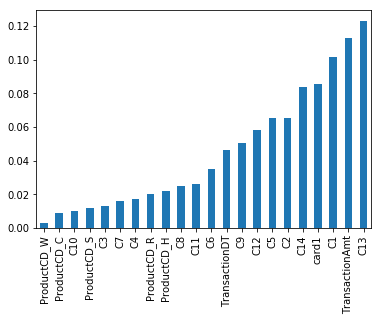

In [22]:
importance.plot.bar()